In [ ]:
import pandas as pd 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import random
import os 

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import cv2
import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import copy 

In [ ]:
os.listdir('/tf/notebooks/data/bone/')

In [2]:
ct = np.load('/tf/notebooks/data/bone/256d1_2239.npy')
test_ct = np.load('/tf/notebooks/data/bone/256d1_457.npy')
bmd = np.load('/tf/notebooks/data/bone/bmd2239.npy')
test_bmd = np.load('/tf/notebooks/data/bone/bmd457.npy')
tsc = np.load('/tf/notebooks/data/bone/tsc2239c.npy')
test_tsc = np.load('/tf/notebooks/data/bone/tsc457c.npy')

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

# 내가 사용할 GPU번호(0,1,2,3)
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    try: # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus: 
            tf.config.experimental.set_memory_growth(gpu, True)
             
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') 
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    
    except RuntimeError as e: # Memory growth must be set before GPUs have been initialized 
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
seed = 1

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# normalize
CT=(ct-np.min(ct))/(np.max(ct)-np.min(ct))
tCT = (test_ct-np.min(test_ct))/(np.max(test_ct)-np.min(test_ct))

In [6]:
test_feature = tCT
# test_bmd = test_bmd
train_feature01 = CT
train_bmd1 = bmd

In [7]:
def n01(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [31]:
#check test set
models = []

for i in range(10):
    globals()['model0' + str(i)] = tf.keras.models.load_model(f'./models/256/bmd2696_orgs1_res22hb_{i}.h5',compile=False)
    models.append(globals()['model0' + str(i)])
    
pred_test_raw = [model.predict(test_feature) for model in models]    
pred_test = np.mean([model.predict(test_feature) for model in models], axis=0)
pred_train = np.mean([model.predict(CT) for model in models], axis=0)

In [12]:
pred_train = np.load('./result/pred_s1_bmd2696train_orgs1_res22hb.npy')
pred_test = np.load('./result/pred_s1_bmd2696test_orgs1_res22hb.npy')
import scipy.stats as stats
corr_test =stats.pearsonr(pred_test.ravel(),test_bmd)
corr_train =stats.pearsonr(pred_train.ravel(),bmd)
print('train set : ',corr_train)
print('test set : ',corr_test)

train set :  (0.9409684271578436, 0.0)
test set :  (0.9049302964956908, 6.207978062902332e-171)


In [40]:
def MAPE(y,pred):
    return np.mean(np.abs((y-pred)/y)*100)
mape_test =MAPE(pred_test.ravel(),test_bmd)
mape_train =MAPE(pred_train.ravel(),bmd)
print('train set : ',mape_train)
print('test set : ',mape_test)

train set :  3.930020439341432
test set :  5.656339806247691


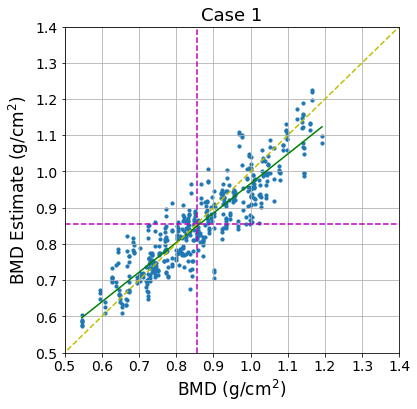

In [13]:
pred = pred_test.ravel()
bmdmax = np.max(test_bmd)
bmdmin = np.min(test_bmd)
lin=np.polyfit(test_bmd,pred,1)
lin2=np.poly1d(lin)
x_s= np.linspace(bmdmin, bmdmax)
xx = np.linspace(0.4,1.4)
plt.figure(figsize=(6,6))
plt.scatter(test_bmd, pred, s=10)
plt.plot(x_s,lin2(x_s),color='green')
plt.plot([0.8562, 0.8562], [0.5, 1.4],'m--')
plt.plot([0.5, 1.4],[0.8562, 0.8562],'m--')
plt.plot(xx,xx,'y--')
plt.title('Case 1',fontsize=18)
plt.xlabel('BMD (g/cm$^{2}$)', fontsize=17)
plt.ylabel('BMD Estimate (g/cm$^{2}$)', fontsize=17)
plt.xlim([0.5,1.4])
plt.ylim([0.5,1.4])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

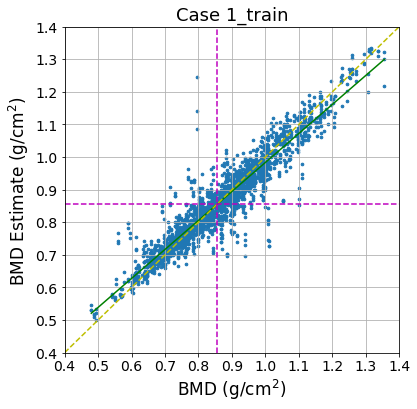

In [14]:
pred_tr = pred_train.ravel()
bmdmax_tr = np.max(bmd)
bmdmin_tr = np.min(bmd)
lin_tr=np.polyfit(bmd,pred_tr,1)
lin2_tr=np.poly1d(lin_tr)
x_s_tr= np.linspace(bmdmin_tr, bmdmax_tr)
xx_tr = np.linspace(0.4,1.4)
tick = np.linspace(0.4,1.4,11)

plt.figure(figsize=(6,6))
plt.scatter(bmd, pred_tr,s=7)
plt.plot(x_s_tr,lin2_tr(x_s_tr),color='green')
plt.plot(xx,xx,'y--')
plt.plot([0.8562, 0.8562], [0.4, 1.4],'m--')
plt.plot([0.4, 1.4],[0.8562, 0.8562],'m--')
plt.xticks(np.arange(0.4, 1.5, 0.1))
plt.yticks(np.arange(0.4, 1.5, 0.1))
plt.title('Case 1_train',fontsize=18)
plt.xlabel('BMD (g/cm$^{2}$)', fontsize=17)
plt.ylabel('BMD Estimate (g/cm$^{2}$) ', fontsize=17)
plt.xlim([0.4,1.4])
plt.ylim([0.4,1.4])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

In [57]:
ref_bmd = 0.9747
std = 0.1185

pred_tsc_test = (pred_test - ref_bmd)/std
pred_tsc_test = pred_tsc_test.ravel()

In [60]:
test_tsc = np.float32(test_tsc)
pred_tsc_test = np.float32(pred_tsc_test)

In [82]:
testlen = len(test_tsc)
ost_label = np.zeros((testlen,))
th = -1.0
for i in range(testlen):
    if (test_tsc[i]<th):
        ost_label[i]=1
    else:
        ost_label[i]=0

ost_pred = np.zeros((testlen,))
for i in range(testlen):
    if (pred_tsc_test[i]<th):
        ost_pred[i]=1
    else:
        ost_pred[i]=0    
        
print('병이 있는 sample # : ',np.sum(ost_label))  
print('전체에 대한 질병 비율 : ',((np.sum(ost_label)/testlen)*100).round(2),'%')

병이 있는 sample # :  232.0
전체에 대한 질병 비율 :  50.77 %


In [84]:
N = len(ost_pred)
accuracy = (ost_label == ost_pred).sum() / N
TP = ((ost_pred == 1) & (ost_label == 1)).sum()
FP = ((ost_pred == 1) & (ost_label == 0)).sum()
FN = ((ost_pred == 0) & (ost_label == 1)).sum()
TN = ((ost_pred == 0) & (ost_label == 0)).sum()
precision = TP / (TP+FP) #병 있다고 예측한 것 중 실제로 병이 있을 확률
specificity = TN / (FP+TN) # 병없는 것중 없다고 예측확률
recall = TP / (TP+FN) #병있는 것중 있다고 예측확률(sensitivity)
F1 = 2*(precision*recall)/(precision+recall)

In [85]:
print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'specificity: {specificity}')
print(f'recall: {recall}')
print(f'F1 score: {F1}')
print(f'TP:{TP}')
print(f'FP:{FP}')
print(f'FN:{FN}')
print(f'TN:{TN}')
print(f'True:{(ost_label == ost_pred).sum()}')

accuracy: 0.862144420131291
precision: 0.8421052631578947
specificity: 0.8266666666666667
recall: 0.896551724137931
F1 score: 0.8684759916492693
TP:208
FP:39
FN:24
TN:186
True:394
